In [49]:
import os
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

dossier_principal  = os.getcwd()
dossier_donnees = os.path.join(dossier_principal, "donnees")
dossier_images  = os.path.join(dossier_principal, "images")

# Chargement des données

- ### Données hospitalières relatives à l'épidémie de COVID-19

Récupérées sur le site des données publiques françaises et provenant de Santé Publique France, mises à jour quotidiennement.

Lien : https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/


- ### Données des urgences hospitalières et de SOS médecins relatives à l'épidémie de COVID-19

Récupérées sur le site des données publiques françaises et provenant de Santé Publique France, mises à jour quotidiennement.

Lien : https://www.data.gouv.fr/fr/datasets/donnees-des-urgences-hospitalieres-et-de-sos-medecins-relatives-a-lepidemie-de-covid-19/


- ### Données liées au recencement de la population française

Récupérées sur le site de l'INSEE. Données parues le 30/12/2019 et correspondantes à la population française en 2017, réparties par département.

Lien : https://www.insee.fr/fr/statistiques/4265429?sommaire=4265511


- ### Données du découpage des communes française

Récupérées sur le site de l'INSEE. Données parues le 26/02/2020 et correspondantes au code officiel géographique au premier janvier 2020.

Lien : https://www.insee.fr/fr/information/4316069


- ### Données mondiales de l'université Johns Hopkins

Récupérées sur le dépôt GitHub, et mises à jour quotidiennement.

Lien : https://github.com/CSSEGISandData/COVID-19

In [33]:
def renommePays(x):
    if "Mainland China" == x:
        return "China"
    if "Korea, South" == x:
        return "South Korea"
    else:
        return x
    
def renommeDate(x, liste_jours):
    return liste_jours.index(x)+1


# Chargement des données du Covid
donnees = {}
dates = []
heures = []
donnees_eta = {}
dates_eta = []
heures_eta = []

for fichier in os.listdir(os.path.join(dossier_donnees, "covid-19")):
    fnom = fichier.split('.')[0]

    if "donnees-hospitalieres-covid19" in fnom:
        fnom = fnom.replace("donnees-hospitalieres-covid19-", "").split("-")
        aammjj = fnom[0] + fnom[1] + fnom[2]
        hhmm = fnom[3][:2] + fnom[3][3:]
        dates.append(aammjj)
        heures.append(hhmm)
        donnees[aammjj] = pd.read_csv(os.path.join(os.path.join(dossier_donnees, "covid-19"), fichier), sep=";")
        donnees[aammjj] = donnees[aammjj].dropna()
    
    elif "donnees-hospitalieres-etablissements-covid19" in fnom:
        fnom = fnom.replace("donnees-hospitalieres-etablissements-covid19-", "").split("-")
        aammjj = fnom[0] + fnom[1] + fnom[2]
        hhmm = fnom[3][:2] + fnom[3][3:]
        dates_eta.append(aammjj)
        heures_eta.append(hhmm)
        donnees_eta[aammjj] = pd.read_csv(os.path.join(os.path.join(dossier_donnees, "covid-19"), fichier), sep=";")
        


# Chargement des données de la population française
for fichier in os.listdir(os.path.join(dossier_donnees, "population")):
    fnom = fichier.split('.')[0]
    
    if fnom == "Departements":
        donnees_dep = pd.read_csv(os.path.join(os.path.join(dossier_donnees, "population"), fichier), sep=";")
        donnees_dep = donnees_dep.drop(['Unnamed: 7'], axis=1)
    
    if fnom == "Regions":
        donnees_reg = pd.read_csv(os.path.join(os.path.join(dossier_donnees, "population"), fichier), sep=";")
        donnees_reg["CODREG"] = donnees_reg["CODREG"].apply(lambda x: str(x))
    
    if fnom == "departement2020":
        donnees_decoupage = pd.read_csv(os.path.join(os.path.join(dossier_donnees, "population"), fichier), sep=",")
        


# Chargement des données de tous les pays
donnees_monde = pd.DataFrame()
for fichier in os.listdir(os.path.join(dossier_donnees, "csse_covid_19_daily_reports")):

    if (fichier != ".gitignore") and (fichier != "README.md"):
        fnom = fichier.split('.')[0]
        etude = pd.read_csv(os.path.join(os.path.join(dossier_donnees, "csse_covid_19_daily_reports"), fichier), sep=",")

        if "Country/Region" in etude.columns.tolist():
            etude = etude.rename(columns={"Country/Region": "Country_Region"})
        etude["Country_Region"] = etude["Country_Region"].apply(renommePays)
        etude = etude.groupby(['Country_Region'], as_index=False).sum()
        if "Active" not in etude.columns.tolist():
            etude["Active"] = etude["Confirmed"]
        etude = etude[["Country_Region", "Confirmed", "Deaths", "Recovered", "Active"]]
        etude[["Confirmed", "Deaths", "Recovered", "Active"]] = etude[["Confirmed", "Deaths", "Recovered", "Active"]].astype('int32')
        etude["Day"] = etude["Country_Region"].apply(lambda x: fnom)
        donnees_monde = pd.concat([donnees_monde, etude])
    
donnees_monde = donnees_monde.sort_values(['Day'], ascending=True)
donnees_monde["Day_Count"] = donnees_monde["Day"].apply(renommeDate, liste_jours=donnees_monde["Day"].unique().tolist())
donnees_monde = donnees_monde.reset_index(drop=True)


donnees_monde

,Country_Region,Confirmed,Deaths,Recovered,Active,Day,Day_Count
0,Japan,2,0,0,2,01-22-2020,1
1,China,547,17,28,547,01-22-2020,1
2,Macau,1,0,0,1,01-22-2020,1
3,South Korea,1,0,0,1,01-22-2020,1
4,Taiwan,1,0,0,1,01-22-2020,1
...,...,...,...,...,...,...,...
8774,India,15722,521,2463,12738,04-18-2020,88
8775,Indonesia,6248,535,631,5082,04-18-2020,88
8776,Iran,80868,5031,55987,19850,04-18-2020,88
8777,Guatemala,235,7,21,207,04-18-2020,88


In [3]:
decoupage_reg = {str(i):el for i, el in zip(donnees_reg["CODREG"].values, donnees_reg["REG"].values)}
decoupage_dep = {str(i):el for i, el in zip(donnees_dep["CODDEP"].values, donnees_dep["DEP"].values)}
dep_vers_reg  = {str(i):el for i, el in zip(donnees_decoupage["dep"].values, donnees_decoupage["reg"].values)}

In [4]:
donnees_dep

,CODDEP,DEP,NBARR,NBCAN,NBCOM,PMUN,PTOT
0,01,Ain,4,23.0,393,643350,659180
1,02,Aisne,5,21.0,800,534490,546527
2,03,Allier,3,19.0,317,337988,347035
3,04,Alpes-de-Haute-Provence,4,15.0,198,163915,168381
4,05,Hautes-Alpes,2,15.0,162,141284,145883
...,...,...,...,...,...,...,...
95,95,Val-d'Oise,3,21.0,184,1228618,1239262
96,971,Guadeloupe,2,21.0,32,390253,396153
97,972,Martinique,4,NaN,34,372594,377711
98,973,Guyane,2,NaN,22,268700,271124


# Table des données des départements

In [5]:
donnees_etude_dep = donnees[dates[-1]]
donnees_etude_dep

donnees_etude_dep["reg"] = donnees_etude_dep["dep"].apply(lambda x: str(dep_vers_reg[str(x)]))
donnees_etude_dep

,dep,sexe,jour,hosp,rea,rad,dc,reg
0,01,0,2020-03-18,2,0,1,0,84
1,01,1,2020-03-18,1,0,1,0,84
2,01,2,2020-03-18,1,0,0,0,84
3,02,0,2020-03-18,41,10,18,11,32
4,02,1,2020-03-18,19,4,11,6,32
...,...,...,...,...,...,...,...,...
9694,974,1,2020-04-18,11,2,41,0,4
9695,974,2,2020-04-18,3,0,48,0,4
9696,976,0,2020-04-18,24,5,41,4,6
9697,976,1,2020-04-18,18,5,24,4,6


# Table des données des régions

In [6]:
etude = donnees_etude_dep.copy()

etude = etude.drop(["dep"], axis=1)
etude = etude.reset_index(drop=True)

donnees_etude_reg = pd.DataFrame()
for jour in etude["jour"].unique():
    for sexe in etude["sexe"].unique():
        etude_tempo = etude[(etude["jour"]==jour) & (etude["sexe"]==sexe)]
        etude_tempo = etude_tempo.groupby(['reg'], as_index=False).sum()
        etude_tempo["jour"] = etude_tempo["reg"].apply(lambda x: jour)
        etude_tempo["sexe"] = etude_tempo["reg"].apply(lambda x: sexe)
        donnees_etude_reg = pd.concat([donnees_etude_reg, etude_tempo])
del etude, etude_tempo

donnees_etude_reg

,reg,sexe,hosp,rea,rad,dc,jour
0,1,0,0,0,0,0,2020-03-18
1,11,0,957,294,129,36,2020-03-18
2,2,0,16,5,0,1,2020-03-18
3,24,0,14,5,0,1,2020-03-18
4,27,0,168,33,20,6,2020-03-18
...,...,...,...,...,...,...,...
13,75,2,357,53,504,103,2020-04-18
14,76,2,382,49,828,123,2020-04-18
15,84,2,1381,128,1795,390,2020-04-18
16,93,2,795,101,1280,208,2020-04-18


# Table des données du pays

In [7]:
etude = donnees_etude_dep.copy()

etude = etude.drop(["dep", "reg"], axis=1)
etude = etude.reset_index(drop=True)

donnees_etude_pays = pd.DataFrame()
for sexe in etude["sexe"].unique():
    etude_tempo = etude[etude["sexe"]==sexe]
    etude_tempo = etude_tempo.groupby(['jour'], as_index=False).sum()
    etude_tempo["sexe"] = etude_tempo["jour"].apply(lambda x: sexe)
    donnees_etude_pays = pd.concat([donnees_etude_pays, etude_tempo])
del etude, etude_tempo

donnees_etude_pays

,jour,sexe,hosp,rea,rad,dc
0,2020-03-18,0,2972,771,816,218
1,2020-03-19,0,4073,1002,1180,327
2,2020-03-20,0,5226,1297,1587,450
3,2020-03-21,0,5900,1453,1811,525
4,2020-03-22,0,6954,1674,2117,632
...,...,...,...,...,...,...
27,2020-04-14,2,14351,1744,13046,3953
28,2020-04-15,2,14244,1682,14028,4194
29,2020-04-16,2,14098,1622,14868,4377
30,2020-04-17,2,14162,1557,15591,4546


In [8]:
donnees_pays = donnees_dep.copy()
donnees_pays["PAYS"] = donnees_pays["DEP"].apply(lambda x: "France")
donnees_pays = donnees_pays.drop(["DEP", "CODDEP"], axis=1)
donnees_pays = donnees_pays.reset_index(drop=True)
donnees_pays = donnees_pays.groupby(['PAYS'], as_index=False).sum()

donnees_pays

,PAYS,NBARR,NBCAN,NBCOM,PMUN,PTOT
0,France,332,2041.0,34953,66524339,67761092


# Fonctions utiles par département

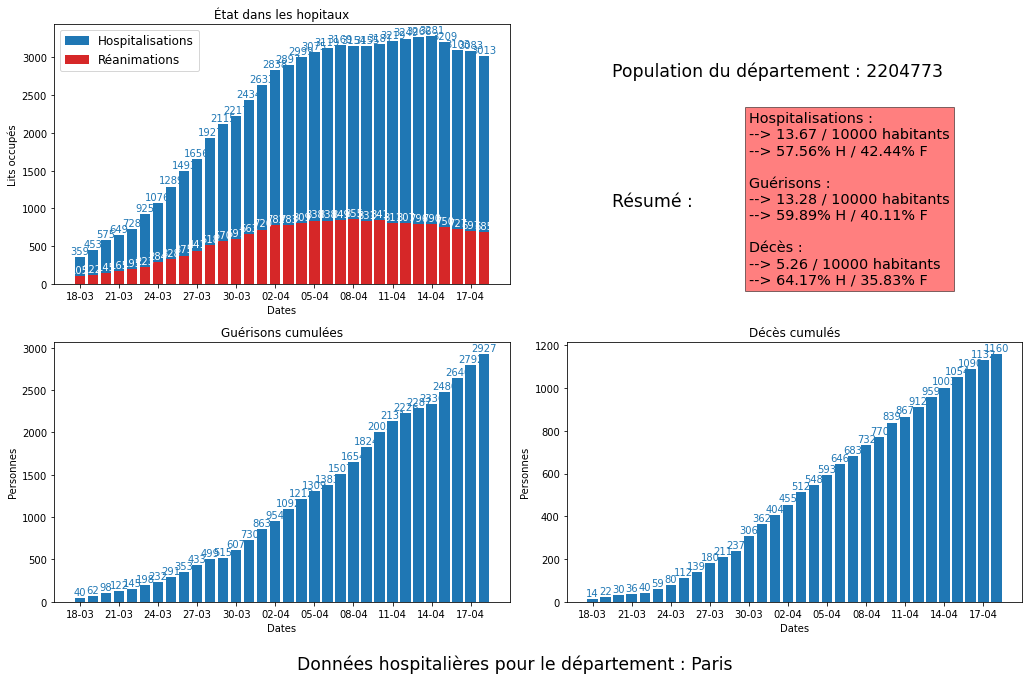

In [83]:
def dateRenomme(row):
    return row[8:]+"-"+row[5:7]

def autolabel(rects, axe=None, color=None):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        if math.isnan(height):
            continue
        axe.annotate('{0}'.format(int(height)),
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 1),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom',
                     color=color)


def afficheDepartement(idDep, etude=None, pop=None, sauvegarde=False):
    if pop == None:
        pop = donnees_dep.copy()
    if etude == None:
        etude = donnees_etude_dep.copy()
    etude = etude[etude["dep"]==str(idDep)]
    
    # Répartition Hommes / Femmes :
    etude_h = etude[etude["sexe"]==1]
    etude_f = etude[etude["sexe"]==2]
    hosp_h_f = [round(etude_h["hosp"].values[-1] / (etude_f["hosp"].values[-1] + etude_h["hosp"].values[-1]) * 100,2),
                round(etude_f["hosp"].values[-1] / (etude_f["hosp"].values[-1] + etude_h["hosp"].values[-1]) * 100,2)]
    rad_h_f = [round(etude_h["rad"].values[-1] / (etude_f["rad"].values[-1] + etude_h["rad"].values[-1]) * 100,2),
               round(etude_f["rad"].values[-1] / (etude_f["rad"].values[-1] + etude_h["rad"].values[-1]) * 100,2)]
    dc_h_f = [round(etude_h["dc"].values[-1] / (etude_f["dc"].values[-1] + etude_h["dc"].values[-1]) * 100,2),
              round(etude_f["dc"].values[-1] / (etude_f["dc"].values[-1] + etude_h["dc"].values[-1]) * 100,2)]
    # Total des genres (des fois supérieur à la somme H + F)
    etude = etude[etude["sexe"]==0]
    
    # Données de population
    pop = pop[pop["CODDEP"]==str(idDep)]
    nom_dep = pop["DEP"].values[0]
    pop_dep = pop["PTOT"].values[0]
    
    # Renommage des dates
    etude["jour"] = etude["jour"].apply(dateRenomme)
    sos_dates = [el for (i, el) in enumerate(etude["jour"].unique()) if i%3==0] 
    
    # Initialisation de la figure
    fig = plt.figure(figsize=(2*8,2*5))

    # Sous figure 1
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.set_title("État dans les hopitaux")
    b1 = plt.bar(etude["jour"], etude["hosp"], color="C0")
    autolabel(b1, axe=ax1, color="C0")
    b2 = plt.bar(etude["jour"], etude["rea"], color="C3")
    autolabel(b2, axe=ax1, color="w")
    plt.ylabel("Lits occupés")
    plt.xlabel("Dates")
    plt.legend((b1[0], b2[0]), ('Hospitalisations', 'Réanimations'), loc="upper left", fontsize="large")
    plt.xticks(sos_dates)

    # Sous figure 2
    ax2 = fig.add_subplot(2, 2, 2, frameon=False)
    msg  =  "Population du département : "
    msg += str(pop_dep)
    plt.text(0.1, 0.8, msg, fontsize="xx-large")
    msg = "Résumé :"
    plt.text(0.1, 0.3, msg, fontsize="xx-large")
    msg  = "Hospitalisations :"
    msg += "\n--> {0} / 10000 habitants".format(round(etude["hosp"].values[-1]/pop_dep*10000, 2))
    msg += "\n--> {0}% H / {1}% F".format(hosp_h_f[0], hosp_h_f[1])
    msg += "\n\n"
    msg += "Guérisons :"
    msg += "\n--> {0} / 10000 habitants".format(round(etude["rad"].values[-1]/pop_dep*10000, 2))
    msg += "\n--> {0}% H / {1}% F".format(rad_h_f[0], rad_h_f[1])
    msg += "\n\n"
    msg += "Décès :"
    msg += "\n--> {0} / 10000 habitants".format(round(etude["dc"].values[-1]/pop_dep*10000, 2))
    msg += "\n--> {0}% H / {1}% F".format(dc_h_f[0], dc_h_f[1])
    plt.text(0.4, 0.0, msg, fontsize="x-large", bbox=dict(facecolor='red', alpha=0.5))
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

    # Sous figure 3
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.set_title("Guérisons cumulées")
    b3 = plt.bar(etude["jour"], etude["rad"], color="C0")
    plt.ylabel("Personnes")
    plt.xlabel("Dates")
    autolabel(b3, ax3, color="C0")
    plt.xticks(sos_dates)

    # Sous figure 4
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.set_title("Décès cumulés")
    b4 = plt.bar(etude["jour"], etude["dc"], color="C0")
    plt.ylabel("Personnes")
    plt.xlabel("Dates")
    autolabel(b4, ax4, color="C0")
    plt.xticks(sos_dates)
    
    fig.suptitle("Données hospitalières pour le département : {0}".format(nom_dep), y=0.035, fontsize="xx-large")
    fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
    
    if sauvegarde:
        plt.savefig(os.path.join(dossier_images, "afficheDepartement-{0}".format(idDep)))
    
    
afficheDepartement(75)

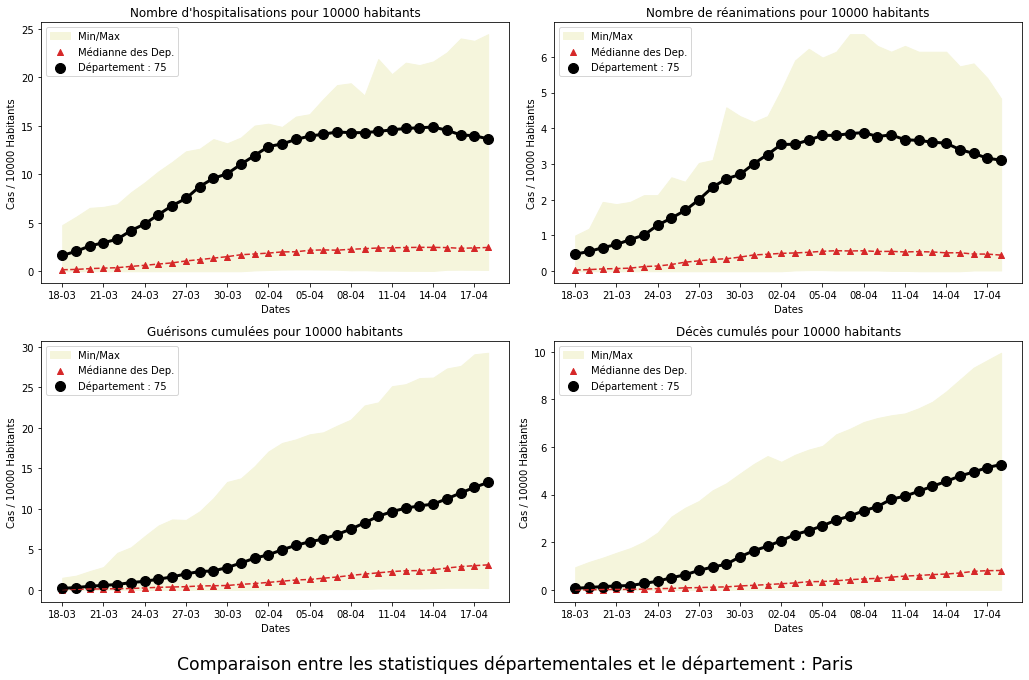

In [82]:
def f(row):
    donnee = row.values[0]
    pop    = row.values[1]
    return donnee/pop*10000


def departementVsTous(idDep, etude=None, pop=None, sauvegarde=False):
    if pop == None:
        pop = donnees_dep.copy()
    if etude == None:
        etude = donnees_etude_dep.copy()
    donnees_stat_tot = []
    donnees_stat_dep = []
    for date in etude["jour"].unique():

        donnees_pop = etude[etude["sexe"]==0]
        donnees_pop = donnees_pop[donnees_pop["jour"]==date]
        donnees_pop = donnees_pop.drop(columns=["sexe", "jour"])
        donnees_pop = donnees_pop.reset_index(drop=True)
        donnees_pop = donnees_pop.drop([100])
        if len(donnees_pop) > 100:
            donnees_pop = donnees_pop.drop([101])
        donnees_pop["pop"] = pop["PTOT"].values

        # Calcule de la part de population
        donnees_pop["stat-hosp"] = donnees_pop[["hosp", "pop"]].apply(f, axis=1)
        donnees_pop["stat-rea"]  = donnees_pop[["rea", "pop"]].apply(f, axis=1)
        donnees_pop["stat-rad"]  = donnees_pop[["rad", "pop"]].apply(f, axis=1)
        donnees_pop["stat-dc"]   = donnees_pop[["dc", "pop"]].apply(f, axis=1)

        # Calcule des données statistiques sur tous les départements
        donnees_stat = []
        for col in donnees_pop.columns.values.tolist():
            if "stat" in col:
                sub_stat = []
                sub_stat.append(donnees_pop[col].mean())
                sub_stat.append(donnees_pop[col].std())
                sub_stat.append(donnees_pop[col].median())
                sub_stat.append(donnees_pop[col].var())
                sub_stat.append(donnees_pop[col].min())
                sub_stat.append(donnees_pop[col].max())
                donnees_stat.append(sub_stat)
        donnees_stat_tot.append(donnees_stat)

        # Pour le département en question    
        nom_dep = pop[pop["CODDEP"]==str(idDep)]["DEP"].values[0]
        stats = ["stat-hosp", "stat-rea", "stat-rad", "stat-dc"]
        donnees_stat_dep.append([donnees_pop[donnees_pop["dep"]==str(idDep)][stat].values[0] for stat in stats])

    
    # Renommage des dates
    etude["jour"] = etude["jour"].apply(dateRenomme)
    sos_dates = [el for (i, el) in enumerate(etude["jour"].unique()) if i%3==0] 

    # Initialisation de la figure
    fig = plt.figure(figsize=(2*8,2*5))

    titres = ["Nombre d'hospitalisations pour 10000 habitants",
              "Nombre de réanimations pour 10000 habitants",
              "Guérisons cumulées pour 10000 habitants",
              "Décès cumulés pour 10000 habitants"]
    for k in range(len(titres)):
        # Sous figure k
        ax1 = fig.add_subplot(2, 2, k+1).set_title(titres[k])
        plt.fill_between(etude["jour"].unique(), [el[k][4] for el in donnees_stat_tot], [el[k][5] for el in donnees_stat_tot], label="Min/Max", color="beige")
#        plt.scatter(etude["jour"].unique(), [el[k][0] for el in donnees_stat_tot], c="C2", marker="*", label="Moyenne des Dep.")
#        plt.plot(etude["jour"].unique(),    [el[k][0] for el in donnees_stat_tot], c="C2", ls="--")
        plt.scatter(etude["jour"].unique(), [el[k][2] for el in donnees_stat_tot], c="C3", marker="^", label="Médianne des Dep.")
        plt.plot(etude["jour"].unique(),    [el[k][2] for el in donnees_stat_tot], c="C3", ls="--")
        plt.scatter(etude["jour"].unique(), [el[k] for el in donnees_stat_dep], c="black", s=100, label="Département : {0}".format(idDep))
        plt.plot(etude["jour"].unique(),    [el[k] for el in donnees_stat_dep], c="black", linewidth=3)
#        sns.violinplot(x="jour", y="")
        plt.legend(loc="upper left")
        plt.ylabel("Cas / 10000 Habitants")
        plt.xlabel("Dates")    
        plt.xticks(sos_dates)
    
    fig.suptitle("Comparaison entre les statistiques départementales et le département : {0}".format(nom_dep), y=0.035, fontsize="xx-large")
    fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
    
    if sauvegarde:
        plt.savefig(os.path.join(dossier_images, "departementVsTous-{0}".format(idDep)))
        
departementVsTous(75)

/home/alexbdg/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


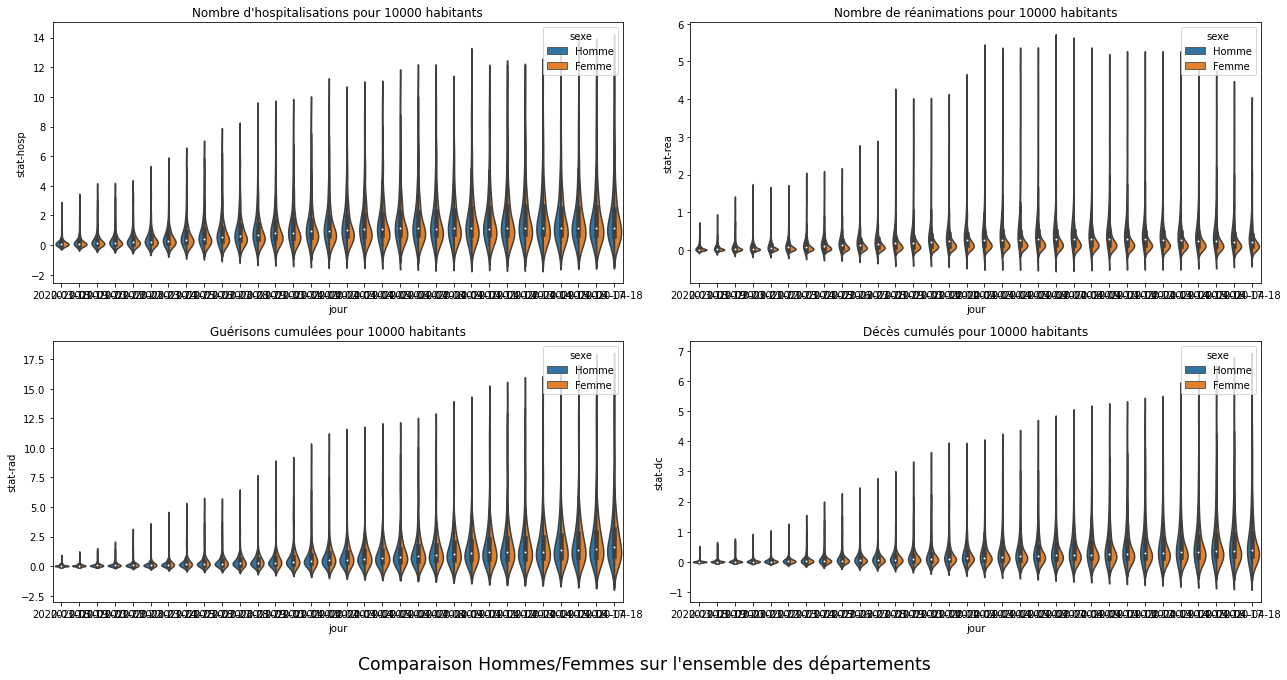

In [81]:
def changeNom(sexe):
    if sexe == 0:
        sexe = "Total"
    elif sexe == 1:
        sexe = "Homme"
    elif sexe == 2:
        sexe = "Femme"
    return sexe


donnees_pop_tot = pd.DataFrame()
for date in donnees_etude_dep["jour"].unique():
    
    for sexe in donnees_etude_dep["sexe"].unique()[1:]:
    
        donnees_pop = donnees_etude_dep[donnees_etude_dep["sexe"]==sexe]
        donnees_pop["sexe"] = donnees_pop["sexe"].apply(changeNom)
        donnees_pop = donnees_pop[donnees_pop["jour"]==date]
        donnees_pop = donnees_pop.reset_index(drop=True)
        donnees_pop = donnees_pop.drop([100])
        if len(donnees_pop) > 100:
            donnees_pop = donnees_pop.drop([101])
        donnees_pop["pop"] = donnees_dep["PTOT"].values

        # Calcule de la part de population
        donnees_pop["stat-hosp"] = donnees_pop[["hosp", "pop"]].apply(f, axis=1)
        donnees_pop["stat-rea"]  = donnees_pop[["rea", "pop"]].apply(f, axis=1)
        donnees_pop["stat-rad"]  = donnees_pop[["rad", "pop"]].apply(f, axis=1)
        donnees_pop["stat-dc"]   = donnees_pop[["dc", "pop"]].apply(f, axis=1)
        

        donnees_pop_tot = pd.concat([donnees_pop_tot, donnees_pop], ignore_index=True)

titres = ["Nombre d'hospitalisations pour 10000 habitants",
          "Nombre de réanimations pour 10000 habitants",
          "Guérisons cumulées pour 10000 habitants",
          "Décès cumulés pour 10000 habitants"]
stats = ["stat-hosp", "stat-rea", "stat-rad", "stat-dc"]
        
# Initialisation de la figure
fig = plt.figure(figsize=(2*10,2*5))

for k in range(len(titres)):
    ax = fig.add_subplot(2, 2, k+1)
    sns.violinplot(x="jour", y=stats[k], hue="sexe", data=donnees_pop_tot, split=True, axes=ax, kind="violin")
    ax.set_title(titres[k])
    
fig.suptitle("Comparaison Hommes/Femmes sur l'ensemble des départements", y=0.035, fontsize="xx-large")
fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

# Maintenant les données regroupées par régions

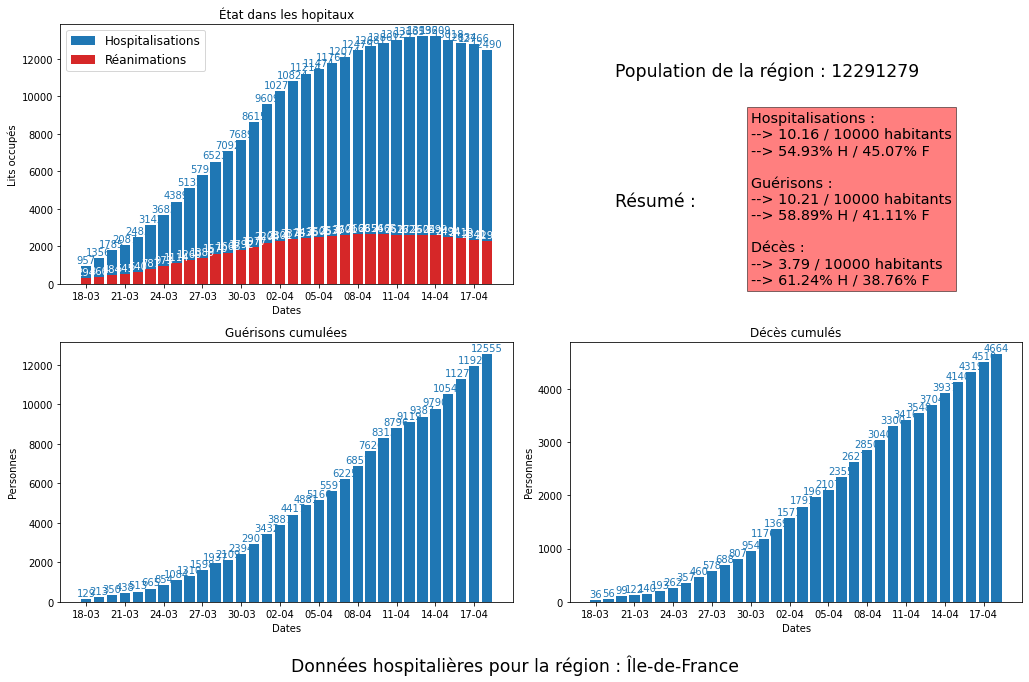

In [79]:
def afficheRegion(idReg, etude=None, pop=None, sauvegarde=False):
    if pop == None:
        pop = donnees_reg.copy()
    if etude == None:
        etude = donnees_etude_reg.copy()
    etude = etude[etude["reg"]==str(idReg)]
    
    # Répartition Hommes / Femmes :
    etude_h = etude[etude["sexe"]==1]
    etude_f = etude[etude["sexe"]==2]
    hosp_h_f = [round(etude_h["hosp"].values[-1] / (etude_f["hosp"].values[-1] + etude_h["hosp"].values[-1]) * 100,2),
                round(etude_f["hosp"].values[-1] / (etude_f["hosp"].values[-1] + etude_h["hosp"].values[-1]) * 100,2)]
    rad_h_f = [round(etude_h["rad"].values[-1] / (etude_f["rad"].values[-1] + etude_h["rad"].values[-1]) * 100,2),
               round(etude_f["rad"].values[-1] / (etude_f["rad"].values[-1] + etude_h["rad"].values[-1]) * 100,2)]
    dc_h_f = [round(etude_h["dc"].values[-1] / (etude_f["dc"].values[-1] + etude_h["dc"].values[-1]) * 100,2),
              round(etude_f["dc"].values[-1] / (etude_f["dc"].values[-1] + etude_h["dc"].values[-1]) * 100,2)]
    # Total des genres (des fois supérieur à la somme H + F)
    etude = etude[etude["sexe"]==0]
    
    # Données de population
    pop = pop[pop["CODREG"]==str(idReg)]
    nom_reg = pop["REG"].values[0]
    pop_reg = pop["PTOT"].values[0]
    
    # Renommage des dates
    etude["jour"] = etude["jour"].apply(dateRenomme)
    sos_dates = [el for (i, el) in enumerate(etude["jour"].unique()) if i%3==0] 
    
    # Initialisation de la figure
    fig = plt.figure(figsize=(2*8,2*5))

    # Sous figure 1
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.set_title("État dans les hopitaux")
    b1 = plt.bar(etude["jour"], etude["hosp"], color="C0")
    autolabel(b1, axe=ax1, color="C0")
    b2 = plt.bar(etude["jour"], etude["rea"], color="C3")
    autolabel(b2, axe=ax1, color="w")
    plt.ylabel("Lits occupés")
    plt.xlabel("Dates")
    plt.legend((b1[0], b2[0]), ('Hospitalisations', 'Réanimations'), loc="upper left", fontsize="large")
    plt.xticks(sos_dates)

    # Sous figure 2
    ax2 = fig.add_subplot(2, 2, 2, frameon=False)
    msg  =  "Population de la région : "
    msg += str(pop_reg)
    plt.text(0.1, 0.8, msg, fontsize="xx-large")
    msg = "Résumé :"
    plt.text(0.1, 0.3, msg, fontsize="xx-large")
    msg  = "Hospitalisations :"
    msg += "\n--> {0} / 10000 habitants".format(round(etude["hosp"].values[-1]/pop_reg*10000, 2))
    msg += "\n--> {0}% H / {1}% F".format(hosp_h_f[0], hosp_h_f[1])
    msg += "\n\n"
    msg += "Guérisons :"
    msg += "\n--> {0} / 10000 habitants".format(round(etude["rad"].values[-1]/pop_reg*10000, 2))
    msg += "\n--> {0}% H / {1}% F".format(rad_h_f[0], rad_h_f[1])
    msg += "\n\n"
    msg += "Décès :"
    msg += "\n--> {0} / 10000 habitants".format(round(etude["dc"].values[-1]/pop_reg*10000, 2))
    msg += "\n--> {0}% H / {1}% F".format(dc_h_f[0], dc_h_f[1])
    plt.text(0.4, 0.0, msg, fontsize="x-large", bbox=dict(facecolor='red', alpha=0.5))
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

    # Sous figure 3
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.set_title("Guérisons cumulées")
    b3 = plt.bar(etude["jour"], etude["rad"], color="C0")
    plt.ylabel("Personnes")
    plt.xlabel("Dates")
    autolabel(b3, ax3, color="C0")
    plt.xticks(sos_dates)

    # Sous figure 4
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.set_title("Décès cumulés")
    b4 = plt.bar(etude["jour"], etude["dc"], color="C0")
    plt.ylabel("Personnes")
    plt.xlabel("Dates")
    autolabel(b4, ax4, color="C0")
    plt.xticks(sos_dates)
    
    fig.suptitle("Données hospitalières pour la région : {0}".format(nom_reg), y=0.035, fontsize="xx-large")
    fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
    
    if sauvegarde:
        plt.savefig(os.path.join(dossier_images, "afficheRegion-{0}".format(idReg)))
    
    
afficheRegion(11)

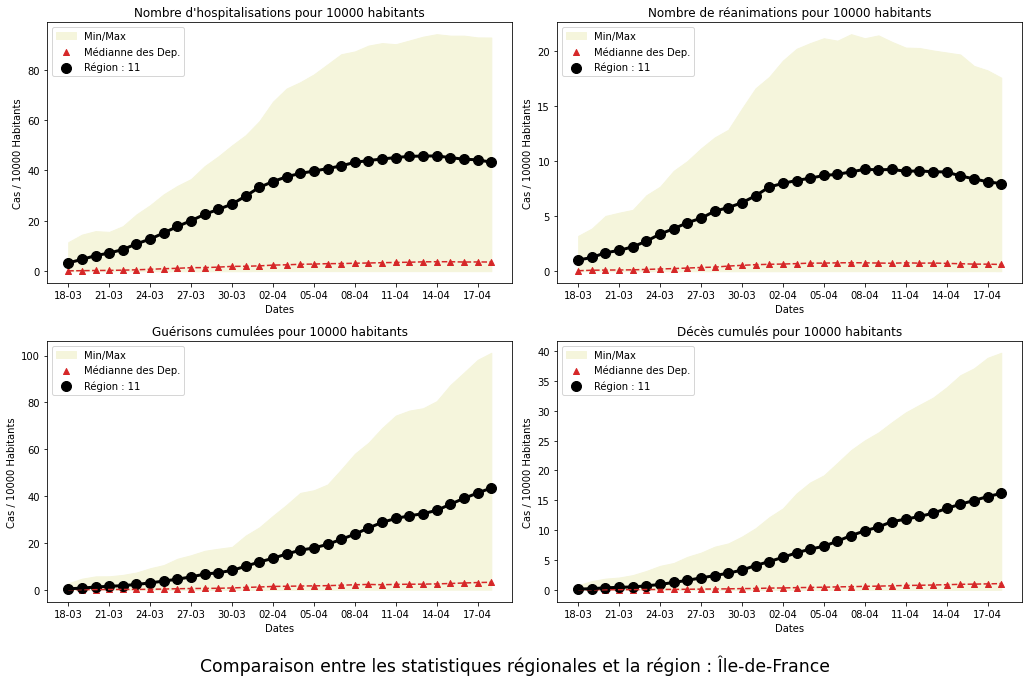

In [78]:
def regionVsTous(idReg, etude=None, pop=None, sauvegarde=False):
    if pop == None:
        pop = donnees_reg.copy()
    if etude == None:
        etude = donnees_etude_reg.copy()
    donnees_stat_tot = []
    donnees_stat_reg = []
    for date in etude["jour"].unique():

        donnees_pop = etude[etude["sexe"]==0]
        donnees_pop = donnees_pop[donnees_pop["jour"]==date]
        donnees_pop = donnees_pop.drop(columns=["sexe", "jour"])
        donnees_pop = donnees_pop.reset_index(drop=True)
        if len(donnees_pop) > 17:
            donnees_pop = donnees_pop.drop([12])
        donnees_pop["pop"] = pop["PTOT"].values

        # Calcule de la part de population
        donnees_pop["stat-hosp"] = donnees_pop[["hosp", "pop"]].apply(f, axis=1)
        donnees_pop["stat-rea"]  = donnees_pop[["rea", "pop"]].apply(f, axis=1)
        donnees_pop["stat-rad"]  = donnees_pop[["rad", "pop"]].apply(f, axis=1)
        donnees_pop["stat-dc"]   = donnees_pop[["dc", "pop"]].apply(f, axis=1)

        # Calcule des données statistiques sur tous les départements
        donnees_stat = []
        for col in donnees_pop.columns.values.tolist():
            if "stat" in col:
                sub_stat = []
                sub_stat.append(donnees_pop[col].mean())
                sub_stat.append(donnees_pop[col].std())
                sub_stat.append(donnees_pop[col].median())
                sub_stat.append(donnees_pop[col].var())
                sub_stat.append(donnees_pop[col].min())
                sub_stat.append(donnees_pop[col].max())
                donnees_stat.append(sub_stat)
        donnees_stat_tot.append(donnees_stat)

        # Pour le département en question    
        nom_reg = pop[pop["CODREG"]==str(idReg)]["REG"].values[0]
        stats = ["stat-hosp", "stat-rea", "stat-rad", "stat-dc"]
        donnees_stat_reg.append([donnees_pop[donnees_pop["reg"]==str(idReg)][stat].values[0] for stat in stats])

    
    # Renommage des dates
    etude["jour"] = etude["jour"].apply(dateRenomme)
    sos_dates = [el for (i, el) in enumerate(etude["jour"].unique()) if i%3==0] 

    # Initialisation de la figure
    fig = plt.figure(figsize=(2*8,2*5))

    titres = ["Nombre d'hospitalisations pour 10000 habitants",
              "Nombre de réanimations pour 10000 habitants",
              "Guérisons cumulées pour 10000 habitants",
              "Décès cumulés pour 10000 habitants"]
    for k in range(len(titres)):
        # Sous figure k
        ax1 = fig.add_subplot(2, 2, k+1).set_title(titres[k])
        plt.fill_between(etude["jour"].unique(), [el[k][4] for el in donnees_stat_tot], [el[k][5] for el in donnees_stat_tot], label="Min/Max", color="beige")
        plt.scatter(etude["jour"].unique(), [el[k][2] for el in donnees_stat_tot], c="C3", marker="^", label="Médianne des Dep.")
        plt.plot(etude["jour"].unique(),    [el[k][2] for el in donnees_stat_tot], c="C3", ls="--")
        plt.scatter(etude["jour"].unique(), [el[k] for el in donnees_stat_reg], c="black", s=100, label="Région : {0}".format(idReg))
        plt.plot(etude["jour"].unique(),    [el[k] for el in donnees_stat_reg], c="black", linewidth=3)
        plt.legend(loc="upper left")
        plt.ylabel("Cas / 10000 Habitants")
        plt.xlabel("Dates")
        plt.xticks(sos_dates)
    
    fig.suptitle("Comparaison entre les statistiques régionales et la région : {0}".format(nom_reg), y=0.035, fontsize="xx-large")
    fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
    
    if sauvegarde:
        plt.savefig(os.path.join(dossier_images, "regionVsTous-{0}".format(idReg)))
        
regionVsTous(11)

# Maintenant les données regroupées pour la France

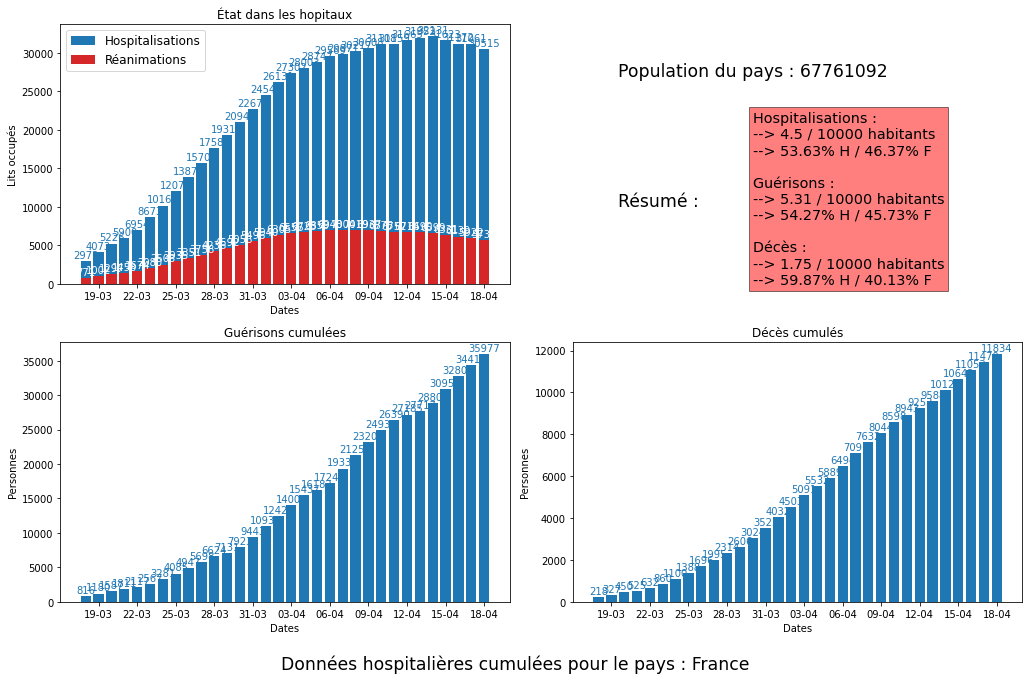

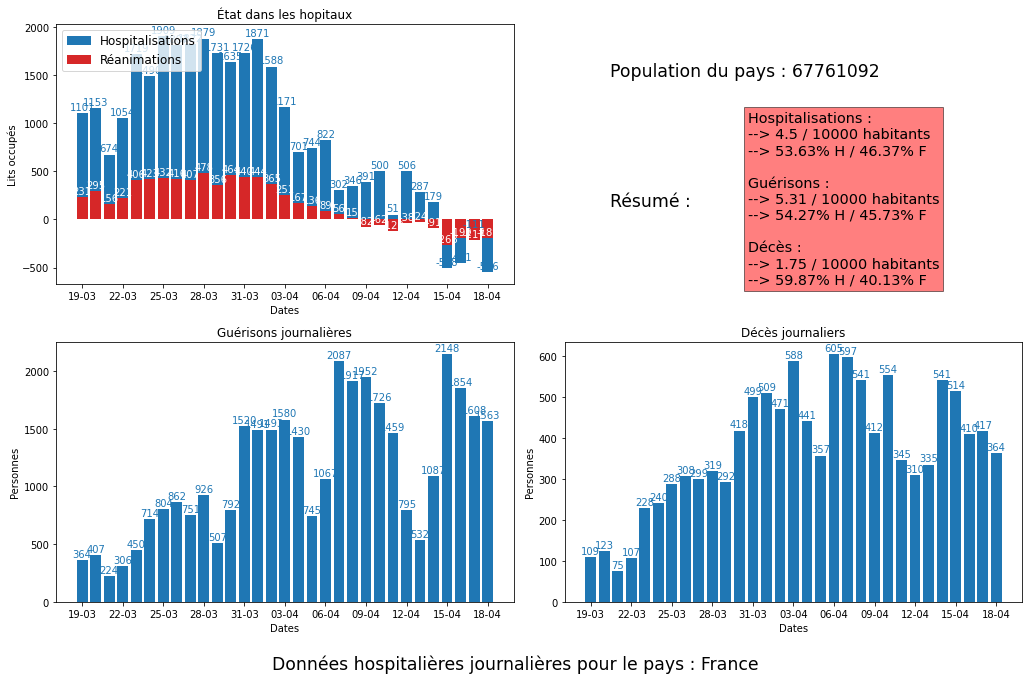

In [75]:
def affichePays(etude=None, pop=None, sauvegarde=False):
    if pop == None:
        pop = donnees_pays.copy()
    if etude == None:
        etude = donnees_etude_pays.copy()
    
    # Répartition Hommes / Femmes :
    etude_h = etude[etude["sexe"]==1]
    etude_f = etude[etude["sexe"]==2]
    hosp_h_f = [round(etude_h["hosp"].values[-1] / (etude_f["hosp"].values[-1] + etude_h["hosp"].values[-1]) * 100,2),
                round(etude_f["hosp"].values[-1] / (etude_f["hosp"].values[-1] + etude_h["hosp"].values[-1]) * 100,2)]
    rad_h_f = [round(etude_h["rad"].values[-1] / (etude_f["rad"].values[-1] + etude_h["rad"].values[-1]) * 100,2),
               round(etude_f["rad"].values[-1] / (etude_f["rad"].values[-1] + etude_h["rad"].values[-1]) * 100,2)]
    dc_h_f = [round(etude_h["dc"].values[-1] / (etude_f["dc"].values[-1] + etude_h["dc"].values[-1]) * 100,2),
              round(etude_f["dc"].values[-1] / (etude_f["dc"].values[-1] + etude_h["dc"].values[-1]) * 100,2)]
    # Total des genres (des fois supérieur à la somme H + F)
    etude = etude[etude["sexe"]==0]
    
    # Données de population
    nom_pays = "France"
    pop_pays = pop["PTOT"].values[0]
    
    # Renommage des dates
    etude["jour"] = etude["jour"].apply(dateRenomme)
    sos_dates = [el for (i, el) in enumerate(etude["jour"].drop(0).values) if i%3==0] 
    
    # Initialisation de la figure
    fig = plt.figure(figsize=(2*8,2*5))

    # Sous figure 1
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.set_title("État dans les hopitaux")
    b1 = plt.bar(etude["jour"], etude["hosp"], color="C0")
    autolabel(b1, axe=ax1, color="C0")
    b2 = plt.bar(etude["jour"], etude["rea"], color="C3")
    autolabel(b2, axe=ax1, color="w")
    plt.ylabel("Lits occupés")
    plt.xlabel("Dates")
    plt.legend((b1[0], b2[0]), ('Hospitalisations', 'Réanimations'), loc="upper left", fontsize="large")
    plt.xticks(sos_dates)

    # Sous figure 2
    ax2 = fig.add_subplot(2, 2, 2, frameon=False)
    msg  =  "Population du pays : "
    msg += str(pop_pays)
    plt.text(0.1, 0.8, msg, fontsize="xx-large")
    msg = "Résumé :"
    plt.text(0.1, 0.3, msg, fontsize="xx-large")
    msg  = "Hospitalisations :"
    msg += "\n--> {0} / 10000 habitants".format(round(etude["hosp"].values[-1]/pop_pays*10000, 2))
    msg += "\n--> {0}% H / {1}% F".format(hosp_h_f[0], hosp_h_f[1])
    msg += "\n\n"
    msg += "Guérisons :"
    msg += "\n--> {0} / 10000 habitants".format(round(etude["rad"].values[-1]/pop_pays*10000, 2))
    msg += "\n--> {0}% H / {1}% F".format(rad_h_f[0], rad_h_f[1])
    msg += "\n\n"
    msg += "Décès :"
    msg += "\n--> {0} / 10000 habitants".format(round(etude["dc"].values[-1]/pop_pays*10000, 2))
    msg += "\n--> {0}% H / {1}% F".format(dc_h_f[0], dc_h_f[1])
    plt.text(0.4, 0.0, msg, fontsize="x-large", bbox=dict(facecolor='red', alpha=0.5))
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)

    # Sous figure 3
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.set_title("Guérisons cumulées")
    b3 = plt.bar(etude["jour"], etude["rad"], color="C0")
    plt.ylabel("Personnes")
    plt.xlabel("Dates")
    autolabel(b3, ax3, color="C0")
    plt.xticks(sos_dates)

    # Sous figure 4
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.set_title("Décès cumulés")
    b4 = plt.bar(etude["jour"], etude["dc"], color="C0")
    plt.ylabel("Personnes")
    plt.xlabel("Dates")
    autolabel(b4, ax4, color="C0")
    plt.xticks(sos_dates)

    fig.suptitle("Données hospitalières cumulées pour le pays : {0}".format(nom_pays), y=0.035, fontsize="xx-large")
    fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
    
    if sauvegarde:
        plt.savefig(os.path.join(dossier_images, "affichePaysCumule"))
    
    
    # Initialisation de la figure
    fig = plt.figure(figsize=(2*8,2*5))

    # Sous figure 1
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.set_title("État dans les hopitaux")
    b1 = plt.bar(etude["jour"].drop(0), etude["hosp"].diff().dropna(), color="C0")
    autolabel(b1, axe=ax1, color="C0")
    b2 = plt.bar(etude["jour"].drop(0), etude["rea"].diff().dropna(), color="C3")
    autolabel(b2, axe=ax1, color="w")
    plt.ylabel("Lits occupés")
    plt.xlabel("Dates")
    plt.legend((b1[0], b2[0]), ('Hospitalisations', 'Réanimations'), loc="upper left", fontsize="large")
    plt.xticks(sos_dates)

    # Sous figure 2
    ax2 = fig.add_subplot(2, 2, 2, frameon=False)
    msg  =  "Population du pays : "
    msg += str(pop_pays)
    plt.text(0.1, 0.8, msg, fontsize="xx-large")
    msg = "Résumé :"
    plt.text(0.1, 0.3, msg, fontsize="xx-large")
    msg  = "Hospitalisations :"
    msg += "\n--> {0} / 10000 habitants".format(round(etude["hosp"].values[-1]/pop_pays*10000, 2))
    msg += "\n--> {0}% H / {1}% F".format(hosp_h_f[0], hosp_h_f[1])
    msg += "\n\n"
    msg += "Guérisons :"
    msg += "\n--> {0} / 10000 habitants".format(round(etude["rad"].values[-1]/pop_pays*10000, 2))
    msg += "\n--> {0}% H / {1}% F".format(rad_h_f[0], rad_h_f[1])
    msg += "\n\n"
    msg += "Décès :"
    msg += "\n--> {0} / 10000 habitants".format(round(etude["dc"].values[-1]/pop_pays*10000, 2))
    msg += "\n--> {0}% H / {1}% F".format(dc_h_f[0], dc_h_f[1])
    plt.text(0.4, 0.0, msg, fontsize="x-large", bbox=dict(facecolor='red', alpha=0.5))
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
    # Sous figure 3
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.set_title("Guérisons journalières")
    b3 = plt.bar(etude["jour"].drop(0), etude["rad"].diff().dropna(), color="C0")
    plt.ylabel("Personnes")
    plt.xlabel("Dates")
    autolabel(b3, ax3, color="C0")
    plt.xticks(sos_dates)

    # Sous figure 4
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.set_title("Décès journaliers")
    b4 = plt.bar(etude["jour"].drop(0), etude["dc"].diff().dropna(), color="C0")
    plt.ylabel("Personnes")
    plt.xlabel("Dates")
    autolabel(b4, ax4, color="C0")
    plt.xticks(sos_dates)

    fig.suptitle("Données hospitalières journalières pour le pays : {0}".format(nom_pays), y=0.035, fontsize="xx-large")
    fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
    
    if sauvegarde:
        plt.savefig(os.path.join(dossier_images, "affichePaysJournalier"))
    
    
affichePays()

# Données SOS medecin

In [15]:
# Chargement des données du Covid
donnees_sos = {}

for fichier in os.listdir(os.path.join(dossier_donnees, "covid-19")):
    fnom = fichier.split('.')[0]

    if "sursaud-covid19-quotidien" in fnom:

        if "departement" in fnom:
            donnees_sos["departement"] = pd.read_csv(os.path.join(os.path.join(dossier_donnees, "covid-19"), fichier), sep=",")

        if "region" in fnom:
            donnees_sos["region"] = pd.read_csv(os.path.join(os.path.join(dossier_donnees, "covid-19"), fichier), sep=",")

        if "france" in fnom:
            donnees_sos["pays"] = pd.read_csv(os.path.join(os.path.join(dossier_donnees, "covid-19"), fichier), sep=",")

In [16]:
donnees_sos["pays"]

,fra,date_de_passage,sursaud_cl_age_corona,nbre_pass_corona,nbre_pass_tot,nbre_hospit_corona,nbre_pass_corona_h,nbre_pass_corona_f,nbre_pass_tot_h,nbre_pass_tot_f,nbre_hospit_corona_h,nbre_hospit_corona_f,nbre_acte_corona,nbre_acte_tot,nbre_acte_corona_h,nbre_acte_corona_f,nbre_acte_tot_h,nbre_acte_tot_f
0,FR,2020-02-24,0,1.0,48476.0,NaN,NaN,1.0,25342.0,23129.0,NaN,NaN,NaN,12071.0,NaN,NaN,5195.0,6819.0
1,FR,2020-02-24,A,NaN,10459.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3330.0,NaN,NaN,NaN,NaN
2,FR,2020-02-24,B,1.0,17610.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5224.0,NaN,NaN,NaN,NaN
3,FR,2020-02-24,C,NaN,9402.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1948.0,NaN,NaN,NaN,NaN
4,FR,2020-02-24,D,NaN,4210.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,556.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,FR,2020-04-17,A,34.0,3186.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,23.0,781.0,NaN,NaN,NaN,NaN
320,FR,2020-04-17,B,601.0,7401.0,91.0,NaN,NaN,NaN,NaN,NaN,NaN,237.0,2101.0,NaN,NaN,NaN,NaN
321,FR,2020-04-17,C,549.0,5235.0,192.0,NaN,NaN,NaN,NaN,NaN,NaN,112.0,1047.0,NaN,NaN,NaN,NaN
322,FR,2020-04-17,D,184.0,2315.0,103.0,NaN,NaN,NaN,NaN,NaN,NaN,29.0,405.0,NaN,NaN,NaN,NaN


In [17]:
def idVersRegion(idReg):
    etude = donnees_reg[donnees_reg["CODREG"]==str(idReg)]
    return etude["REG"].values[0]

def idVersDepartement(idDep):
    etude = donnees_dep[donnees_dep["CODDEP"]==str(idDep)]
    return etude["DEP"].values[0]

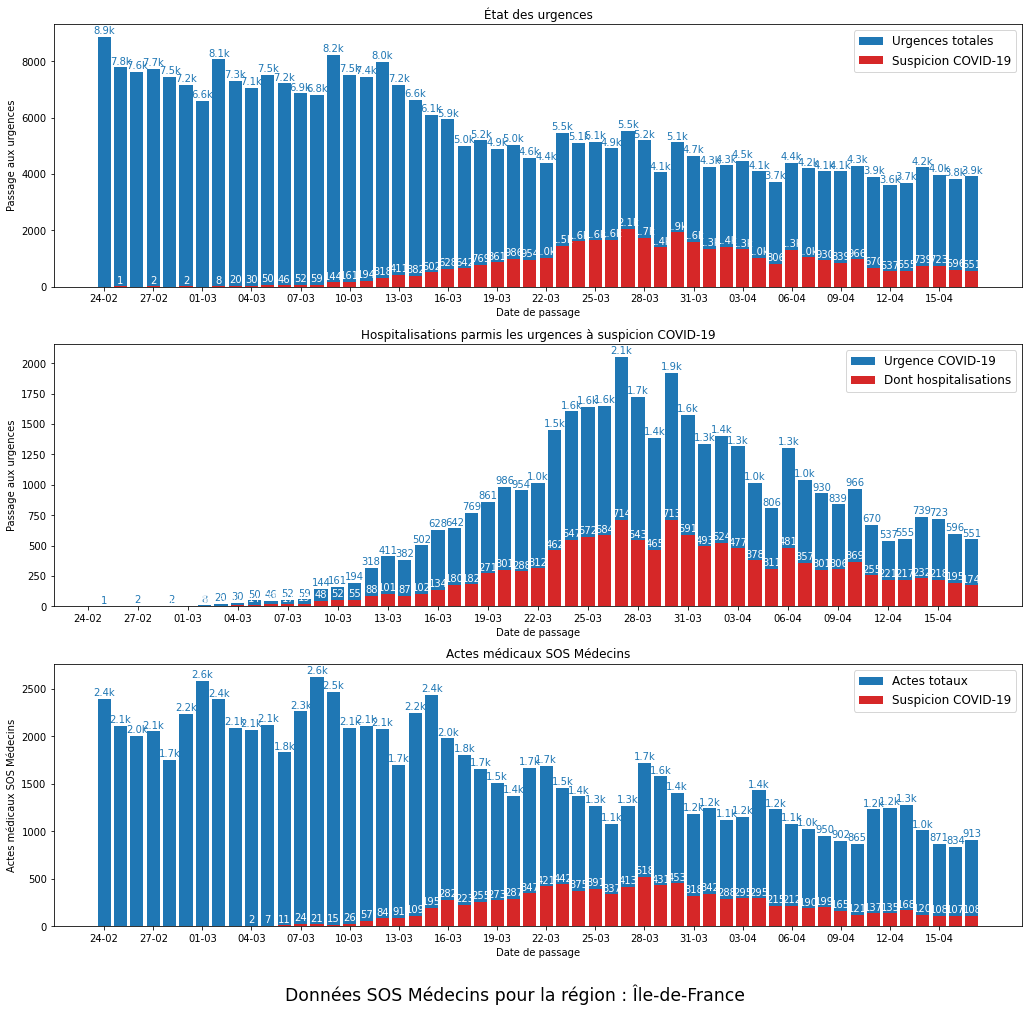

In [91]:
def autolabel2(rects, axe=None, color=None):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        if math.isnan(height):
            continue
        if height > 9999:
            message = '{0}k'.format(int(height//1000))
        elif height > 999:
            message = '{0}k'.format(round(height/1000, 1))
        else:
            message = str(int(height))
        axe.annotate(message,
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 1),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom',
                     color=color)
        

def sosMedecins(idDep=None, idReg=None, sauvegarde=False):
    if idDep is not None:
        etude = donnees_sos["departement"].copy()
        if idDep < 10:
            idDep = "0" + str(idDep)
        etude = etude[etude["dep"]==str(idDep)]
        decoupage = "le département"
        nom_etude = idVersDepartement(idDep)
        nom_sauvegarde = "afficheSOSDepartement-" + str(idDep)
        
    elif idReg is not None:
        etude = donnees_sos["region"].copy()
        etude = etude[etude["reg"]==idReg]
        decoupage = "la région"
        nom_etude = idVersRegion(idReg)
        nom_sauvegarde = "afficheSOSRegion-" + str(idReg)
        
    else:
        etude = donnees_sos["pays"].copy()
        decoupage = "le pays"
        nom_etude = "France"
        nom_sauvegarde = "afficheSOSPays"
    
    
    # On selectionne la tranche d'âge des patients (ici tous)
    etude = etude[etude["sursaud_cl_age_corona"]=="0"]
    
    # Renommage des dates
    etude["date_de_passage"] = etude["date_de_passage"].apply(dateRenomme)
    sos_dates = [el for (i, el) in enumerate(etude["date_de_passage"].values) if i%3==0]
    
    plot_lines = 1
    plot_fig2, plot_fig3 = False, False
    if (etude["nbre_pass_corona"].isna().sum() != len(etude["nbre_pass_corona"])) or \
        (etude["nbre_hospit_corona"].isna().sum() != len(etude["nbre_hospit_corona"])):
        plot_fig2 = True
        plot_lines += 1
    if (etude["nbre_acte_tot"].isna().sum() != len(etude["nbre_acte_tot"])) or \
        (etude["nbre_acte_corona"].isna().sum() != len(etude["nbre_acte_corona"])):
        plot_fig3 = True
        plot_lines += 1
    
    # Initialisation de la figure
    fig = plt.figure(figsize=(16,plot_lines*5))

    # Sous figure 1
    ax1 = fig.add_subplot(plot_lines, 1, 1)
    ax1.set_title("État des urgences")
    b1 = plt.bar(etude["date_de_passage"], etude["nbre_pass_tot"], color="C0")
    autolabel2(b1, axe=ax1, color="C0")
    b2 = plt.bar(etude["date_de_passage"], etude["nbre_pass_corona"], color="C3")
    autolabel2(b2, axe=ax1, color="w")
    plt.ylabel("Passage aux urgences")
    plt.xlabel("Date de passage")
    plt.xticks(sos_dates)
    plt.legend((b1[0], b2[0]), ('Urgences totales', 'Suspicion COVID-19'), fontsize="large")
    iter_fig = 2

    # Sous figure 2
    if plot_fig2:
        ax2 = fig.add_subplot(plot_lines, 1, iter_fig)
        ax2.set_title("Hospitalisations parmis les urgences à suspicion COVID-19")
        b1 = plt.bar(etude["date_de_passage"], etude["nbre_pass_corona"], color="C0")
        autolabel2(b1, axe=ax2, color="C0")
        b2 = plt.bar(etude["date_de_passage"], etude["nbre_hospit_corona"], color="C3")
        autolabel2(b2, axe=ax2, color="w")
        plt.ylabel("Passage aux urgences")
        plt.xlabel("Date de passage")
        plt.xticks(sos_dates)
        plt.legend((b1[0], b2[0]), ('Urgence COVID-19', 'Dont hospitalisations'), fontsize="large")
        iter_fig += 1

    # Sous figure 3
    if plot_fig3:
        ax3 = fig.add_subplot(plot_lines, 1, iter_fig)
        ax3.set_title("Actes médicaux SOS Médecins")
        b1 = plt.bar(etude["date_de_passage"], etude["nbre_acte_tot"], color="C0")
        autolabel2(b1, axe=ax3, color="C0")
        b2 = plt.bar(etude["date_de_passage"], etude["nbre_acte_corona"], color="C3")
        autolabel2(b2, axe=ax3, color="w")
        plt.ylabel("Actes médicaux SOS Médecins")
        plt.xlabel("Date de passage")
        plt.xticks(sos_dates)
        plt.legend((b1[0], b2[0]), ('Actes totaux', 'Suspicion COVID-19'), fontsize="large")

    
    
    fig.suptitle("Données SOS Médecins pour {0} : {1}".format(decoupage ,nom_etude), y=0.035, fontsize="xx-large")
    fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
    
    if sauvegarde:
        plt.savefig(os.path.join(dossier_images, nom_sauvegarde))
        
        
sosMedecins(idReg=11)#idDep=75)

In [40]:
etude = donnees_sos["region"].copy()
etude = etude[etude["reg"]==11]
etude

,reg,date_de_passage,sursaud_cl_age_corona,nbre_pass_corona,nbre_pass_tot,nbre_hospit_corona,nbre_pass_corona_h,nbre_pass_corona_f,nbre_pass_tot_h,nbre_pass_tot_f,nbre_hospit_corona_h,nbre_hospit_corona_f,nbre_acte_corona,nbre_acte_tot,nbre_acte_corona_h,nbre_acte_corona_f,nbre_acte_tot_h,nbre_acte_tot_f
42,11,2020-02-24,0,NaN,8870.0,NaN,NaN,NaN,4519.0,4350.0,NaN,NaN,NaN,2391.0,NaN,NaN,1055.0,1333.0
43,11,2020-02-24,A,NaN,2147.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,655.0,NaN,NaN,NaN,NaN
44,11,2020-02-24,B,NaN,3620.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1043.0,NaN,NaN,NaN,NaN
45,11,2020-02-24,C,NaN,1660.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,434.0,NaN,NaN,NaN,NaN
46,11,2020-02-24,D,NaN,592.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6391,11,2020-04-17,A,10.0,578.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,150.0,NaN,NaN,NaN,NaN
6392,11,2020-04-17,B,214.0,1543.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,53.0,325.0,NaN,NaN,NaN,NaN
6393,11,2020-04-17,C,178.0,953.0,53.0,NaN,NaN,NaN,NaN,NaN,NaN,27.0,179.0,NaN,NaN,NaN,NaN
6394,11,2020-04-17,D,54.0,351.0,29.0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,82.0,NaN,NaN,NaN,NaN


# Regression pour la mortalité

In [19]:
import numpy as np

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import median_absolute_error, r2_score

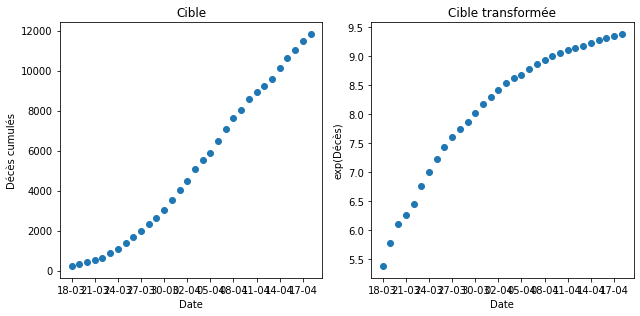

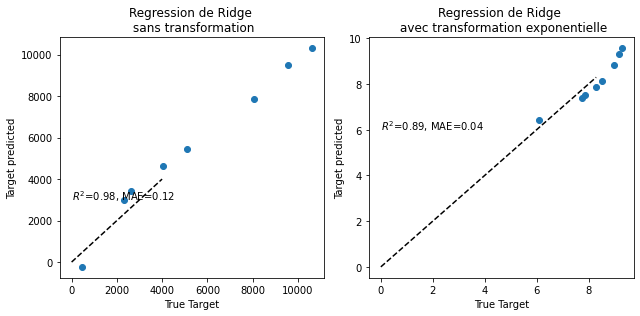

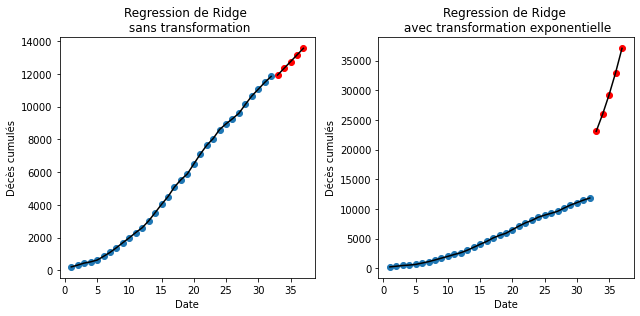

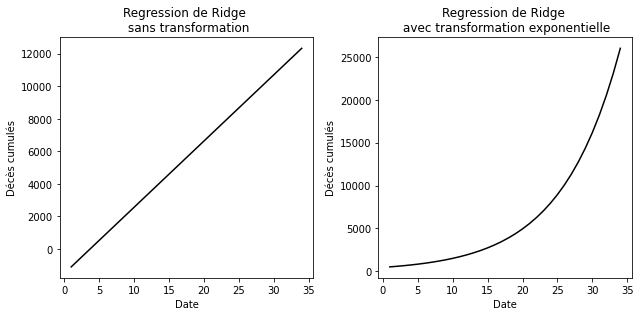

In [20]:
def arcsigmoid(x):
    return np.log(x/(1.-x))

def sigmoid(x):
    return 1./(1.+np.exp(-x))


def predictionTransforme(jours, etude=None):
    if etude==None:
        etude = donnees_etude_pays.copy()
    
    # Transformations sur la table
    etude = etude[etude["sexe"]==0]
    etude = etude.reset_index()
    etude["index"] = etude["index"].apply(lambda x: x+1)
    etude["jour"] = etude["jour"].apply(dateRenomme)
    nb_jours = etude["jour"].count()

    # Définition de la matrice des "features" et de la "target"
    X = np.array(etude["index"]).reshape(-1, 1)
    y = np.array(etude["dc"])
    
    # Application de la fonction de transformation
    y_trans2 = np.log(y)
    
    # Abscisses
    moins_jour = [el for (i, el) in enumerate(etude["jour"].values) if i%3==0]
    
    # Initialisation de la figure
    fig = plt.figure(figsize=(2*5,5))

    fig.add_subplot(1, 2, 1)
    plt.scatter(etude["jour"], y)
    plt.ylabel('Décès cumulés')
    plt.xlabel('Date')
    plt.xticks(moins_jour)
    plt.title('Cible')

    fig.add_subplot(1, 2, 2)
    plt.scatter(etude["jour"], y_trans2)
    plt.ylabel('exp(Décès)')
    plt.xlabel('Date')
    plt.xticks(moins_jour)
    plt.title('Cible transformée')

    fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

    # Création des données de test et d'entrainement
    X_train,        X_test,        y_train,        y_test        = train_test_split(X,        y, random_state=0)
    X_trans2_train, X_trans2_test, y_trans2_train, y_trans2_test = train_test_split(X, y_trans2, random_state=0)
    
    # Début de la régression linéaire
    regr   = RidgeCV()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)

    regr_trans2   = RidgeCV()
    regr_trans2.fit(X_trans2_train, y_trans2_train)
    y_trans2_pred = regr_trans2.predict(X_trans2_test)

    # Initialisation de la figure
    fig = plt.figure(figsize=(2*5,5))

    fig.add_subplot(1, 2, 1)
    plt.scatter(y_test, y_pred)
    plt.plot([0, 4000], [0, 4000], '--k')
    plt.ylabel('Target predicted')
    plt.xlabel('True Target')
    plt.title('Regression de Ridge \n sans transformation')
    plt.text(1, 3000, r'$R^2$=%.2f, MAE=%.2f' % (
        r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred)/4000))

    fig.add_subplot(1, 2, 2)
    plt.scatter(y_trans2_test, y_trans2_pred)
    plt.plot([0, np.log1p(4000)], [0, np.log1p(4000)], '--k')
    plt.ylabel('Target predicted')
    plt.xlabel('True Target')
    plt.title('Regression de Ridge \n avec transformation exponentielle')
    plt.text(0.001, 6, r'$R^2$=%.2f, MAE=%.2f' % (
        r2_score(y_trans2_test, y_trans2_pred), median_absolute_error(y_trans2_test, y_trans2_pred)/np.log1p(4000)))

    fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
    
    
    dfpred = pd.DataFrame({"index":  [i for i in range(nb_jours+1, nb_jours+jours+1) for j in range(1)]})

    # Regression
    regr = RidgeCV()
    regr.fit(X, y)
    pred = regr.predict(np.array(dfpred["index"]).reshape(-1, 1))
    regr2 = RidgeCV()
    regr2.fit(X, y_trans2)
    pred2 = regr2.predict(np.array(dfpred["index"]).reshape(-1, 1))

    # Update database
    dfpred["dc"]  = pred
    dfpred["dc2"] = np.exp(pred2)
    
    # Initialisation des figures
    fig = plt.figure(figsize=(2*5,5))

    fig.add_subplot(1, 2, 1)
    plt.scatter(etude["index"], etude["dc"])
    plt.plot(etude["index"], etude["dc"], c="black")
    plt.scatter(dfpred["index"], dfpred["dc"], c="red")
    plt.plot(dfpred["index"], dfpred["dc"], c="black")
    plt.xlabel('Date')
    plt.ylabel('Décès cumulés')
    plt.title('Regression de Ridge \n sans transformation')

    fig.add_subplot(1, 2, 2)
    plt.scatter(etude["index"], etude["dc"])
    plt.plot(etude["index"], etude["dc"], c="black")
    plt.scatter(dfpred["index"], dfpred["dc2"], c="red")
    plt.plot(dfpred["index"], dfpred["dc2"], c="black")
    plt.xlabel('Date')
    plt.ylabel('Décès cumulés')

    fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
    plt.title('Regression de Ridge \n avec transformation exponentielle')
    
    
    
    # Affichage de toute la courbe
    dates = np.arange(1,35)
    pred  = regr.predict(dates.reshape(-1, 1))
    pred2 = np.exp(regr2.predict(dates.reshape(-1, 1)))
    
    # Initialisation des figures
    fig = plt.figure(figsize=(2*5,5))

    fig.add_subplot(1, 2, 1)
    plt.plot(dates, pred, c="black")
    plt.xlabel('Date')
    plt.ylabel('Décès cumulés')
    plt.title('Regression de Ridge \n sans transformation')

    fig.add_subplot(1, 2, 2)
    plt.plot(dates, pred2, c="black")
    plt.xlabel('Date')
    plt.ylabel('Décès cumulés')

    fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
    plt.title('Regression de Ridge \n avec transformation exponentielle')
    
    
    
    return dfpred, regr.coef_, regr2.coef_



dfpred, coef_, coef_2 = predictionTransforme(5)

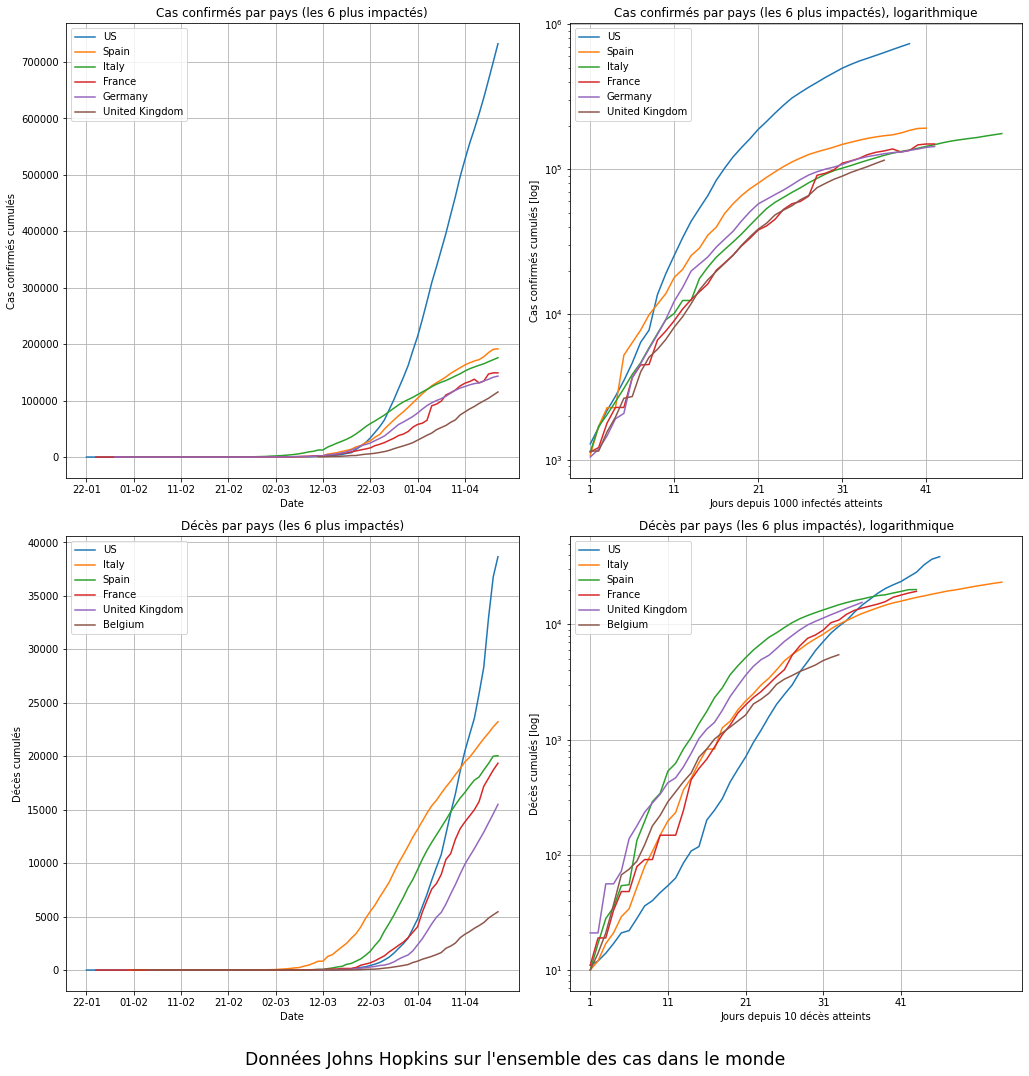

In [35]:
def afficheMonde(etude=None, n_premiers=10, n_infectes=1000, n_deces=10):
    if etude == None:
        etude = donnees_monde.copy()
    etude["Day"] = etude["Day"].apply(lambda x: x[3:5]+"-"+x[:2])
    
    liste_jour = etude["Day"].unique().tolist()
    etude[etude["Day"]==liste_jour[-1]].sort_values(['Deaths'], ascending=False)
    
    # Abscisses
    def ecrireAbscissescompte(min_tot=0):
        max_tot = max(etude["Day_Count"].unique().tolist())
        moins_jour_compte = [el for (i, el) in enumerate(etude["Day_Count"].unique().tolist()) if (i%10==0 and i<(max_tot-min_tot))]
        return moins_jour_compte
    moins_jour        = [el for (i, el) in enumerate(liste_jour) if i%10==0]
    moins_jour_compte = ecrireAbscissescompte()
    
    
    # Initialisation des figures
    fig = plt.figure(figsize=(2*8,2*8))
    
    fig.add_subplot(2, 2, 1)
    liste_pays = etude[etude["Day"]==liste_jour[-1]].sort_values(['Confirmed'], ascending=False).head(n_premiers)["Country_Region"].tolist()
    for pays in liste_pays:
        sous_etude = etude[etude["Country_Region"]==pays].sort_values(['Confirmed'], ascending=False)
        sous_etude = sous_etude.sort_values(['Day_Count'], ascending=True)
        plt.plot(sous_etude["Day_Count"], sous_etude["Confirmed"], label=pays)
    plt.xlabel('Date')
    plt.xticks(moins_jour_compte, moins_jour)
    plt.ylabel('Cas confirmés cumulés')
    plt.title('Cas confirmés par pays (les {0} plus impactés)'.format(n_premiers))
    if n_premiers<16:
        plt.legend()
    plt.grid()
    
    fig.add_subplot(2, 2, 2)
    min_tot = []
    liste_pays = etude[etude["Day"]==liste_jour[-1]].sort_values(['Confirmed'], ascending=False).head(n_premiers)["Country_Region"].tolist()
    for pays in liste_pays:
        sous_etude = etude[etude["Country_Region"]==pays].sort_values(['Confirmed'], ascending=False)
        lignes_enlever = sous_etude[sous_etude["Confirmed"]<n_infectes].index
        sous_etude = sous_etude.drop(lignes_enlever)
        sous_etude = sous_etude.sort_values(['Day_Count'], ascending=True)
        minimum = sous_etude["Day_Count"].min()
        min_tot += [minimum]
        plt.plot(sous_etude["Day_Count"]-minimum+1, sous_etude["Confirmed"], label=pays)
    plt.xlabel('Jours depuis {0} infectés atteints'.format(n_infectes))
    plt.xticks(ecrireAbscissescompte(min_tot=min(min_tot)))
    plt.ylabel('Cas confirmés cumulés [log]')
    plt.yscale("log")
    plt.title('Cas confirmés par pays (les {0} plus impactés), logarithmique'.format(n_premiers))
    if n_premiers<16:
        plt.legend()
    plt.grid()
    
    fig.add_subplot(2, 2, 3)
    liste_pays = etude[etude["Day"]==liste_jour[-1]].sort_values(['Deaths'], ascending=False).head(n_premiers)["Country_Region"].tolist()
    for pays in liste_pays:
        sous_etude = etude[etude["Country_Region"]==pays].sort_values(['Deaths'], ascending=False)
        sous_etude = sous_etude.sort_values(['Day_Count'], ascending=True)
        plt.plot(sous_etude["Day_Count"], sous_etude["Deaths"], label=pays)
    plt.xlabel('Date')
    plt.xticks(moins_jour_compte, moins_jour)
    plt.ylabel('Décès cumulés')
    plt.title('Décès par pays (les {0} plus impactés)'.format(n_premiers))
    if n_premiers<16:
        plt.legend()
    plt.grid()
    
    fig.add_subplot(2, 2, 4)
    liste_pays = etude[etude["Day"]==liste_jour[-1]].sort_values(['Deaths'], ascending=False).head(n_premiers)["Country_Region"].tolist()
    for pays in liste_pays:
        sous_etude = etude[etude["Country_Region"]==pays].sort_values(['Deaths'], ascending=False)
        lignes_enlever = sous_etude[sous_etude["Deaths"]<n_deces].index
        sous_etude = sous_etude.drop(lignes_enlever)
        sous_etude = sous_etude.sort_values(['Day_Count'], ascending=True)
        minimum = sous_etude["Day_Count"].min()
        plt.plot(sous_etude["Day_Count"]-minimum+1, sous_etude["Deaths"], label=pays)
    plt.xlabel('Jours depuis {0} décès atteints'.format(n_deces))
    plt.xticks(ecrireAbscissescompte(min_tot=min(min_tot)))
    plt.ylabel('Décès cumulés [log]')
    plt.yscale("log")
    plt.title('Décès par pays (les {0} plus impactés), logarithmique'.format(n_premiers))
    if n_premiers<16:
        plt.legend()
    plt.grid()
    
    
    fig.suptitle("Données Johns Hopkins sur l'ensemble des cas dans le monde", y=0.035, fontsize="xx-large")
    fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
    
    return sous_etude
        
        
sous_etude = afficheMonde(n_premiers=6)